# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [86]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [87]:
df = pd.read_csv('https://raw.githubusercontent.com/crowwhite1/HomeWorkForPythonHSE/main/train.csv')

In [88]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [89]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [90]:
df.isna().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [91]:
df.fillna("", inplace=True)
df.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [92]:
df.isna().any()

id          False
keyword     False
location    False
text        False
target      False
dtype: bool

In [93]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [94]:
popular_keywords = dict(train['keyword'].value_counts()[:10])

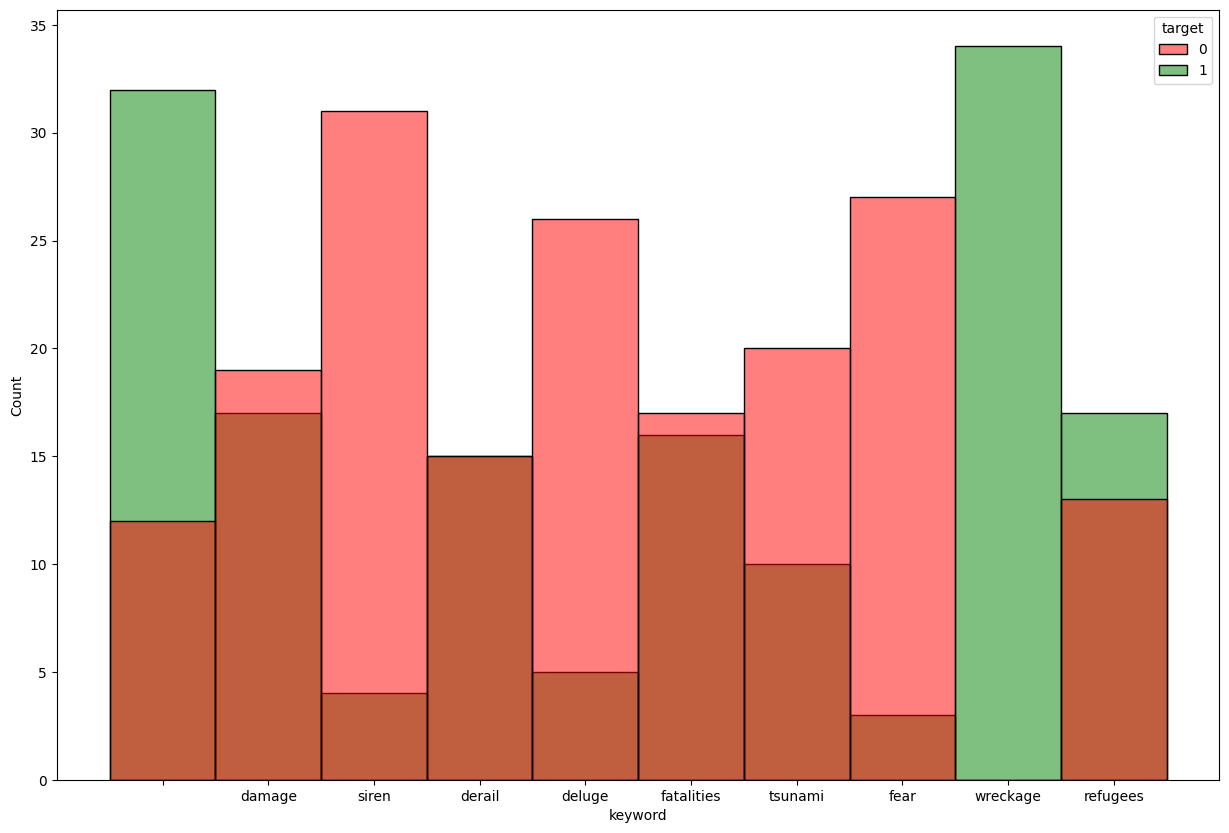

In [95]:
fig = plt.figure(figsize = (15,10))
sns.histplot(x = 'keyword', hue = 'target', data = train[train['keyword'].isin(popular_keywords.keys())], multiple='layer', palette=['red','green'])
plt.show()

**Выводы**: Количество 10-ти наиболее встречающихся значений примерно одинаковое, но вот распределение сильно отличается. Некоторые
ключевые слова чаще встречаются, если катастрофа упоминалась: так, если в твите есть слово wreckage, можно сказать, что
там упоминается о катастрофе. И наоборот: если ключевым было слово siren, то далеко не факт, что пост был о катастрофе, потому
что оно чаще указывает на обратное

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [96]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [97]:
train["keyword"] = train["keyword"].apply(lambda x: x + ' ' if x != "" else x)
train["location"] = train["location"].apply(lambda x: x + ' ' if x != "" else x)
train["text"] = train[["keyword", "location", "text"]].apply("".join, axis=1)
train.drop(["keyword", "location", "id"], axis=1, inplace=True)

In [98]:
test["keyword"] = test["keyword"].apply(lambda x: x + ' ' if x != "" else x)
test["location"] = test["location"].apply(lambda x: x + ' ' if x != "" else x)
test["text"] = test[["keyword", "location", "text"]].apply("".join, axis=1)
test.drop(["keyword", "location", "id"], axis=1, inplace=True)

In [99]:
train.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rota...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [100]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words = 'english')
vectorized_train = vectorizer.fit_transform(train.loc[:,'text'])

In [101]:
vectorized_train.shape

(5329, 18181)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [102]:
vectorizer.vocabulary_

{'bridge': 2899,
 '20collapse': 320,
 'ashes': 1899,
 '2015': 295,
 'australia': 2029,
 'ûªs': 18151,
 'collapse': 3858,
 'trent': 16249,
 'worst': 17546,
 'history': 7664,
 'england': 5652,
 'bundled': 3036,
 '60': 755,
 'http': 7859,
 't5trhjuau0': 15530,
 'hail': 7321,
 'carol': 3308,
 'stream': 15218,
 'illinois': 8136,
 'great': 7108,
 'michigan': 10463,
 'technique': 15684,
 'camp': 3209,
 'b1g': 2117,
 'thanks': 15807,
 'bmurph1019': 2706,
 'hail_youtsey': 7322,
 'termn8r13': 15744,
 'goblue': 6990,
 'wrestleon': 17580,
 'oaskgki6qj': 11493,
 'police': 12458,
 'houston': 7824,
 'cnn': 3799,
 'tennessee': 15727,
 'movie': 10802,
 'theater': 15817,
 'shooting': 14460,
 'suspect': 15430,
 'killed': 9123,
 'di8elzswnr': 4830,
 'rioting': 13621,
 'couple': 4146,
 'hours': 7816,
 'left': 9519,
 'class': 3719,
 'wounds': 17554,
 'lake': 9362,
 'highlands': 7618,
 'crack': 4184,
 'path': 12055,
 'wiped': 17420,
 'morning': 10751,
 'beach': 2354,
 'run': 13870,
 'surface': 15404,
 'elbow

In [103]:
from string import punctuation
def contains_digit(s: str) -> bool:
    return any(map(str.isdigit, s))

def contains_punctuation(s: str) -> bool:
  for x in punctuation:
    if x in s:
      return True
  return False

def is_hashtag(s: str) -> bool:
      return s[0]=='#'

def is_mention(s: str) -> bool:
      return s[0]=='@'

def investigate_vocabulary(vocabulary: dict):
  ans = [0,0,0,0]
  for key in vocabulary.keys():
      if contains_digit(key):
        ans[0]+=1
      if contains_punctuation(key):
        ans[1]+=1
      if is_hashtag(key):
        ans[2]+=1
      if is_mention(key):
        ans[3]+=1
  print('With digit:      ', ans[0]
          )
  print('With punctuation:', ans[1]
          )
  print('Hashtags:        ', ans[2]
          )
  print('Mentions:        ', ans[3]
          )




In [104]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [105]:
investigate_vocabulary(vectorizer.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [106]:
from nltk.tokenize import TweetTokenizer

vectorizer_TweetTokenizer = CountVectorizer(tokenizer=TweetTokenizer().tokenize)


In [107]:
vectorized_train_TweetTokenizer = vectorizer_TweetTokenizer.fit_transform(train.loc[:,'text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [108]:
investigate_vocabulary(vectorizer_TweetTokenizer.vocabulary_
                       )

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** 
С токенизатором CountVectorizer стал уделять намного больше внимания символам, он выделил @ и #, чего не делал без токенизатора,
и оставил гораздо больше знаков препинаний (было 315, стало 7338 уникальных токенов)

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [109]:
from string import punctuation
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [110]:

def contains_only_latin_letters(s: str) -> bool:
    alph = 'abcdefghijklmnopqrstuvwxyz'
    for c in s:
      if c not in alph:
        return False
    return True

def is_emoji(s: str) -> bool:
    for x in s:
      if not x in punctuation:
        return False
    return s.count('(')>0 or s.count(')')>0 or s.count('[')>0 or s.count(']')>0 or s.count('{')>0 or s.count('}')>0

def is_hashtag(s: str) -> bool:
    alph = 'abcdefghijklmnopqrstuvwxyz'
    if s[0]=='#': 
      for x in s[1:]:
        if x not in alph:
          return False
      return True
    return False
    

def tokenize(s: str) -> list[str]:
    return TweetTokenizer().tokenize(s)

def delete_not_eng(tokens: list[str]) -> list[str]:
    tokens_to_return = []
    for token in tokens:
      if contains_only_latin_letters(token) or is_hashtag(token) or is_emoji(token):
        tokens_to_return.append(token)
    return tokens_to_return 



def delete_stop_words(tokens: list[str]) -> list[str]:
        tokens_to_return = []
        for token in tokens:
            if token in nltk.corpus.stopwords.words('english'):
                continue
            else:
                tokens_to_return.append(token)
                
        return tokens_to_return

def stem(tokens: list[str]) -> list[str]:
        tokens_stemmed = [SnowballStemmer('english').stem(x) for x in tokens]
        return tokens_stemmed

def custom_tokenizer(s: str) -> List[str]:    
    s = s.lower()
    tokens = tokenize(s)
    tokens = delete_not_eng(tokens)
    tokens = delete_stop_words(tokens)
    processed_tokens = stem(tokens)
    return processed_tokens


  

In [111]:
custom_tokenizer('She LOVES painting :-) #art %qwert')

['love', 'paint', ':-)', '#art', 'qwert']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [112]:
train_top10_tokenized = train[:10].copy()
train_top10_tokenized['text'] = train_top10_tokenized['text'].apply(lambda x: custom_tokenizer(x))
train_top10_tokenized

,text,target
1186,"[bridg, ash, australia, collaps, trent, bridg,...",0
4071,"[hail, carol, stream, illinoi, great, michigan...",1
5461,"[polic, houston, cnn, tennesse, movi, theater,...",1
5787,"[riot, still, riot, coupl, hour, left, class]",1
7445,"[wound, lake, highland, crack, path, wipe, mor...",0
151,"[airplan, somewher, expert, franc, begin, exam...",1
915,"[bloodi, isol, citi, world, perth, came, kill,...",1
1305,"[burn, except, idk, realli, burn]",0
2570,"[destroy, (, ask, ), destroy, hous]",0
7399,"[wound, maracay, nirgua, venezuela, polic, off...",1


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [113]:
vectorizer = CountVectorizer( tokenizer=custom_tokenizer)

X_train = train['text']
y_train = train['target']
X_test = test['text']
y_test = test['target']
bow = vectorizer.fit_transform(X_train)
bow_test = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


2. Обучите LogisticRegression на полученных признаках.


In [114]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=200,random_state=42)
clf.fit(bow,y_train)


LogisticRegression(max_iter=200, random_state=42)

3. Посчитайте метрику f1-score на тестовых данных.

In [115]:
from sklearn.metrics import classification_report, roc_auc_score

pred = clf.predict(bow_test)
print(classification_report(y_test,pred,digits=3))

              precision    recall  f1-score   support

           0      0.808     0.853     0.830      1318
           1      0.783     0.724     0.752       966

    accuracy                          0.798      2284
   macro avg      0.795     0.788     0.791      2284
weighted avg      0.797     0.798     0.797      2284



## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
bow_tfidf = tfidf_vectorizer.fit_transform(X_train)
bow_test_tfidf = tfidf_vectorizer.transform(X_test)
clf_tfidf = LogisticRegression(max_iter=200, random_state=42)
clf_tfidf.fit(bow_tfidf, y_train)
pred_tfidf = clf_tfidf.predict(bow_test_tfidf)
print(classification_report(y_test, pred_tfidf,digits=3))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0      0.794     0.875     0.832      1318
           1      0.801     0.689     0.741       966

    accuracy                          0.796      2284
   macro avg      0.797     0.782     0.787      2284
weighted avg      0.797     0.796     0.794      2284



1. **Ответ:** Ну... Вроде как никак не изменилось)

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [117]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
bow_tfidf = tfidf_vectorizer.fit_transform(X_train)
bow_test_tfidf = tfidf_vectorizer.transform(X_test)
clf_tfidf = LogisticRegression(max_iter=200, random_state=42)
clf_tfidf.fit(bow_tfidf, y_train)
pred_tfidf = clf_tfidf.predict(bow_test_tfidf)
print(classification_report(y_test, pred_tfidf, digits=3))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0      0.794     0.875     0.832      1318
           1      0.801     0.689     0.741       966

    accuracy                          0.796      2284
   macro avg      0.797     0.782     0.787      2284
weighted avg      0.797     0.796     0.794      2284



2. **Ответ:** Изменение max_df аналогично почти не влияет на качество модели, а лишь уменьшает матрицу

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [118]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=0.001, max_df=0.9)
bow_tfidf = tfidf_vectorizer.fit_transform(X_train)
bow_test_tfidf = tfidf_vectorizer.transform(X_test)
clf_tfidf = LogisticRegression(max_iter=200, random_state=42)
clf_tfidf.fit(bow_tfidf, y_train)
pred_tfidf = clf_tfidf.predict(bow_test_tfidf)
print(classification_report(y_test, pred_tfidf))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1318
           1       0.79      0.70      0.74       966

    accuracy                           0.80      2284
   macro avg       0.79      0.78      0.79      2284
weighted avg       0.79      0.80      0.79      2284



3. **Ответ:** При изменении границ размер матрицы уменьшается, но на качество модели почти не влияет :( Если поставить min_df слишком большим, то f1-score вообще упадет до 0.5

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [119]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
bow_hash = hashing_vectorizer.fit_transform(X_train)
bow_test_hash = hashing_vectorizer.transform(X_test)
clf_hash = LogisticRegression(max_iter=200, random_state=42)
clf_hash.fit(bow_hash, y_train)
pred_hash = clf_hash.predict(bow_test_hash)
print(classification_report(y_test, pred_hash, digits=3))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0      0.780     0.861     0.818      1318
           1      0.779     0.668     0.719       966

    accuracy                          0.779      2284
   macro avg      0.779     0.764     0.769      2284
weighted avg      0.779     0.779     0.776      2284



2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Наилучшим в итоге оказался первоначальный подход с CountVectorizer

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [120]:
# В задании 8 удалось добиться f1-score равным 0.752, соответственно модель с CountVectorizer и custom_tokenizer даёт нам такую меру